In [1]:
# -*- coding: utf-8 -*-
"""minesweeperRL.ipynb
​
Automatically generated by Colaboratory.
​
Original file is located at
    https://colab.research.google.com/drive/186TEoC7_oHRtUtndAcgbuhH0ZAbzowKp
"""
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('drive/My Drive/rl')

Mounted at /content/drive


In [2]:
import numpy as np
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from typing import NamedTuple
from collections import namedtuple

In [3]:
Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward', 'availableAction'))

In [4]:
class MinesweeperReward(NamedTuple):
    win: float = 1.0
    lose: float = -1.0
    progress: float = 0.

In [29]:
class MinesweeperEnv:
    def __init__(self, row=9, col=9, numMines=10):
        self.row = row              # 行（高さ）
        self.col = col              # 列（横幅）
        self.numMines = numMines    # 地雷の個数

        self.mines = np.zeros([self.row, self.col])     # 地雷の位置
        self.neighbors = np.zeros([self.row, self.col]) # 隣接する地雷の個数
        self.state = np.zeros([self.row, self.col])     # 観測状態
        
        self.state.fill(np.nan)
        self.noOpenCell = np.ones(self.row * self.col) # 開いているマス0, 開いていないマス1
        self.reward = MinesweeperReward()   # 報酬
        self.initialized = False    # 初期化判定
        self.won = False            # 成功判定

    # ゲームのリセット
    def reset(self):
        self.mines.fill(0)
        self.neighbors.fill(0)
        self.state.fill(np.nan)
        self.noOpenCell.fill(1)

        self.initialized = False
        self.won = False
        print("state_image in env: ".format(self.state_image()))
        return self.state_image()

    # 1ステップ進める
    def step(self, coordinates):
        reward = self.reward.progress
        done = False
        # 開いているマスを開けた 例外処理
        if not np.isnan(self.state[coordinates[0], coordinates[1]]):
            print('noprogress')
            reward = -1
        # 地雷マスを開けた
        if self.mines[coordinates[0], coordinates[1]] > 0:
            self.state[coordinates[0], coordinates[1]] = -100   # 地雷
            reward = self.reward.lose
            done = True
        # 
        else:
            if not self.initialized:    # 初期化
                self.initializeBoard(coordinates)
                reward = 0.0
            # マスを開く
            self.openCell(coordinates)
            # 終了判定
            if np.sum(np.isnan(self.state)) == self.numMines:
                reward = self.reward.win
                done = True
                self.won = True
        # imshow(self.state_image())
        return self.state_image(), reward, done, {}
    
    def state_image(self):
        screen_arr = np.zeros((self.row*14, self.col*14))
        for i, row in enumerate(self.state):
          for j, col in enumerate(row):
            # 空いてないマス
            if np.isnan(col):
              img_arr = image_arr_dict["nan"]
            # 地雷
            elif int(col) == -100:
              img_arr = image_arr_dict["mine"]
            # 空いているマス
            else:
              img_arr = image_arr_dict[str(int(col))]
            
            w, h = img_arr.shape
            screen_arr[i*w:(i+1)*w, j*h:(j+1)*h] += img_arr
        
        screen_arr = np.ravel(screen_arr)
        screen_tensor = torch.tensor(screen_arr, dtype=torch.float)
        return screen_tensor

    # 盤面の初期化
    def initializeBoard(self, coordinates):
        # 最初のマスは0
        numTotalCells = self.row * self.col
        select = coordinates[0]*self.col + coordinates[1]
        offLimits = np.array([select-self.col-1, select-self.col, select-self.col+1, 
        select-1, select, select+1, 
        select+self.col-1, select+self.col, select+self.col+1])
        availableCells = np.setdiff1d(np.arange(numTotalCells), offLimits)
        # 最初のマスとその周辺以外に爆弾を配置する
        minesFlattend = np.zeros([numTotalCells])
        minesFlattend[np.random.choice(availableCells, self.numMines, replace=False)] = 1
        self.mines = minesFlattend.reshape([self.row, self.col])
        # 隣接する地雷の個数
        for row in range(self.row):
            for col in range(self.col):
                numNeighbors = 0
                for i in range(-1, 2):
                    if row + i >= 0 and row + i < self.row:
                        for j in range(-1, 2):
                            if col + j >= 0 and col + j < self.col:
                                if not (i == 0 and j == 0):
                                    numNeighbors += self.mines[row + i, col + j]
                self.neighbors[row, col] = numNeighbors
        # 初期化終了
        self.initialized = True

    # (coordinates[0], coordinates[1]) のマスを開ける
    def openCell(self, coordinates):
        row = coordinates[0]
        col = coordinates[1]
        self.state[row, col] = self.neighbors[row, col]
        self.noOpenCell[row * self.col + col] = 0   # 開けたマスは0にする
        # 0なら周囲の開いていないマスも開ける
        if self.state[row, col] == 0:
            for i in range(-1, 2):
                if row + i >= 0 and row + i < self.row:
                    for j in range(-1, 2):
                        if col + j >= 0 and col + j < self.col:
                            if np.isnan(self.state[row + i, col + j]):
                                self.openCell([row + i, col + j])

    # ランダムアクション（開いていないマスを開ける）
    def randomAction(self):
        nonOpenCell = np.array(np.where(self.noOpenCell)).flatten()
        action = np.random.choice(nonOpenCell)
        return action

    # 最初の行動の前に地雷設置
    def resetRandomInit(self):
        self.mines.fill(0)
        self.neighbors.fill(0)
        numTotalCells = self.row * self.col
        availableCells = np.arange(numTotalCells)
        minesFlattend = np.zeros([numTotalCells])
        minesFlattend[np.random.choice(availableCells, self.numMines, replace=False)] = 1
        self.mines = minesFlattend.reshape([self.row, self.col])
        # 隣接する地雷の個数
        for row in range(self.row):
            for col in range(self.col):
                numNeighbors = 0
                for i in range(-1, 2):
                    if row + i >= 0 and row + i < self.row:
                        for j in range(-1, 2):
                            if col + j >= 0 and col + j < self.col:
                                if not (i == 0 and j == 0):
                                    numNeighbors += self.mines[row + i, col + j]
                self.neighbors[row, col] = numNeighbors

        self.state.fill(np.nan)
        self.noOpenCell.fill(1)

        self.initialized = True
        self.won = False
        return self.state

    # 固定の地雷配置パターン
    def ResetAndSetMines(self, mines):
        self.mines = np.copy(mines)
        # 隣接する地雷の個数
        for row in range(self.row):
            for col in range(self.col):
                numNeighbors = 0
                for i in range(-1, 2):
                    if row + i >= 0 and row + i < self.row:
                        for j in range(-1, 2):
                            if col + j >= 0 and col + j < self.col:
                                if not (i == 0 and j == 0):
                                    numNeighbors += self.mines[row + i, col + j]
                self.neighbors[row, col] = numNeighbors

        self.state.fill(np.nan)
        self.noOpenCell.fill(1)
        
        self.initialized = True
        self.won = False
        return self.state

In [6]:
class ReplayMemory:
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  # メモリの最大長さ
        self.memory = []  # 経験を保存する変数
        self.index = 0  # 保存するindexを示す変数

    def push(self, state, action, state_next, reward, availableAction):
        '''transition = (state, action, state_next, reward)をメモリに保存する'''
        if len(self.memory) < self.capacity:
            self.memory.append(None)  # メモリが満タンでないときは足す
        self.memory[self.index] = Transition(state, action, state_next, reward, availableAction)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        '''batch_size分だけ、ランダムに保存内容を取り出す'''
        return random.sample(self.memory, batch_size)
        
    def __len__(self):
        '''関数lenに対して、現在の変数memoryの長さを返す'''
        return len(self.memory)

In [7]:
class Net(nn.Module):
    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output

In [22]:
GAMMA = 0.9  # 時間割引率
BATCH_SIZE = 400
CAPACITY = 10**6
class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得

        # 経験を記憶するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)

        # ニューラルネットワークを構築
        n_in, n_mid, n_out = num_states, 64, num_actions
        self.model = Net(n_in, n_mid, n_out)
        print(self.model)  # ネットワークの形を出力

        # 最適化手法の設定
        self.optimizer = optim.Adam(self.model.parameters(), lr=10**-4)

        self.epsilon = 0.5

    def replay(self):
        '''Experience Replayでネットワークの結合パラメータを学習'''
        # -----------------------------------------
        # 1. メモリサイズの確認
        # -----------------------------------------
        # 1.1 メモリサイズがミニバッチより小さい間は何もしない
        if len(self.memory) < BATCH_SIZE:
            return

        # -----------------------------------------
        # 2. ミニバッチの作成
        # -----------------------------------------
        # 2.1 メモリからミニバッチ分のデータを取り出す
        transitions = self.memory.sample(BATCH_SIZE)

        # 2.2 各変数をミニバッチに対応する形に変形
        # transitionsは1stepごとの(state, action, state_next, reward)が、BATCH_SIZE分格納されている
        # つまり、(state, action, state_next, reward)×BATCH_SIZE
        # これをミニバッチにしたい。つまり
        # (state×BATCH_SIZE, action×BATCH_SIZE, state_next×BATCH_SIZE, reward×BATCH_SIZE)にする
        batch = Transition(*zip(*transitions))

        # 2.3 各変数の要素をミニバッチに対応する形に変形し、ネットワークで扱えるようVariableにする
        # 例えばstateの場合、[torch.FloatTensor of size 1x4]がBATCH_SIZE分並んでいるのですが、
        # それを torch.FloatTensor of size BATCH_SIZEx4 に変換します
        # 状態、行動、報酬、non_finalの状態のミニバッチのVariableを作成
        # catはConcatenates（結合）のことです。
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])
        availableAction_batch = torch.cat([a for a in batch.availableAction
                                           if a is not None])
        
        # -----------------------------------------
        # 3. 教師信号となるQ(s_t, a_t)値を求める
        # -----------------------------------------
        # 3.1 ネットワークを推論モードに切り替える
        self.model.eval()

        # 3.2 ネットワークが出力したQ(s_t, a_t)を求める
        # self.model(state_batch)は、右左の両方のQ値を出力しており
        # [torch.FloatTensor of size BATCH_SIZEx2]になっている。
        # ここから実行したアクションa_tに対応するQ値を求めるため、action_batchで行った行動a_tが右か左かのindexを求め
        # それに対応するQ値をgatherでひっぱり出す。
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # 3.3 max{Q(s_t+1, a)}値を求める。ただし次の状態があるかに注意。

        # cartpoleがdoneになっておらず、next_stateがあるかをチェックするインデックスマスクを作成
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                    batch.next_state)), dtype=torch.bool)
        # まずは全部0にしておく
        next_state_values = torch.zeros(BATCH_SIZE)

        # 次の状態があるindexの最大Q値を求める
        # 出力にアクセスし、max(1)で列方向の最大値の[値、index]を求めます
        # そしてそのQ値（index=0）を出力します
        # detachでその値を取り出します
        next_state_values[non_final_mask] = (
            self.model(non_final_next_states)+availableAction_batch).max(1)[0].detach()

        # 3.4 教師となるQ(s_t, a_t)値を、Q学習の式から求める
        expected_state_action_values = reward_batch + GAMMA * next_state_values

        # -----------------------------------------
        # 4. 結合パラメータの更新
        # -----------------------------------------
        # 4.1 ネットワークを訓練モードに切り替える
        self.model.train()

        # 4.2 損失関数を計算する（smooth_l1_lossはHuberloss）
        # expected_state_action_valuesは
        # sizeが[minbatch]になっているので、unsqueezeで[minibatch x 1]へ
        loss = F.smooth_l1_loss(state_action_values,
                                expected_state_action_values.unsqueeze(1))
        
        # 4.3 結合パラメータを更新する
        self.optimizer.zero_grad()  # 勾配をリセット
        loss.backward()  # バックプロパゲーションを計算
        self.optimizer.step()  # 結合パラメータを更新
        
    def decide_action(self, state, availableAction, env):
        '''現在の状態に応じて、行動を決定する'''
        # ε-greedy法で徐々に最適行動のみを採用する

        if self.epsilon <= np.random.uniform(0, 1):
            self.model.eval()  # ネットワークを推論モードに切り替える
            with torch.no_grad():
                # action = (self.model(state)+availableAction).max(1)[1].view(1, 1)
                print("model: ".format(self.model(state)))
                # action = (self.model(state)).max(1)[1].view(1, 1)
                action = (self.model(state))
                #print((self.model(state)*availableAction).max(1)[0].detach())
        else:
            action = torch.LongTensor([[env.randomAction()]])

        return action

    def updateEpsilon(self):
        self.epsilon *= 0.9997
        self.epsilon = max(self.epsilon, 0.1)

In [23]:
class Agent:
    def __init__(self, num_states, num_actions):
        '''課題の状態と行動の数を設定する'''
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための頭脳を生成

    def update_q_function(self):
        '''Q関数を更新する'''
        self.brain.replay()

    def get_action(self, state, availableAction, env):
        '''行動を決定する'''
        action = self.brain.decide_action(state, availableAction, env)
        return action

    def memorize(self, state, action, state_next, reward, availableAction):
        '''memoryオブジェクトに、state, action, state_next, rewardの内容を保存する'''
        self.brain.memory.push(state, action, state_next, reward, availableAction)
        
    def updateEpsilon(self):
        self.brain.updateEpsilon()

In [10]:
def imshow(img):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [11]:
def obsTransform(obs, row, col):
    availableAction = np.zeros((row, col))
    availableAction.fill(-np.inf)
    state = np.zeros((row, col))
    for i in range(row):
        for j in range(col):
            if np.isnan(obs[i, j]):
                availableAction[i, j] = 0
                state[i, j] = -1
            else:
                state[i, j] = obs[i, j]
    state = torch.from_numpy(state.flatten()).type(torch.FloatTensor)
    state = torch.unsqueeze(state, 0)
    availableAction = torch.from_numpy(availableAction.flatten()).type(torch.FloatTensor)
    availableAction = torch.unsqueeze(availableAction, 0)
    
    return state, availableAction

In [27]:
def main():
      
    # main
    import csv
    with open ('data.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['episode', 'step', 'win rate'])

    row = 6
    col = 6
    numMines = 6
    env = MinesweeperEnv(row, col, numMines)
    num_states = row * col * 14 ** 2
    num_actions = row * col
    agent = Agent(num_states, num_actions)  # 環境内で行動するAgentを生成

    # NUM_EPISODES = 500000  # 最大試行回数
    NUM_EPISODES = 3
    win = 0
    lose = 0

    step = 0 # ステップ数

    for episode in range(1, NUM_EPISODES+1):
        print(episode)
        ######******   訓練条件   ******######
        state = env.reset()
        print("initial state: ".format(state))

        # state, availableAction = obsTransform(obs, row, col)
        reward = 0
        done = False

        while not done:  # 1エピソードのループ
            # action = agent.get_action(state, availableAction, env)  # 行動を求める
            action = agent.get_action(state, [], env)  # 行動を求める
            print("action: ".format(action))
            coordinates = divmod(action.item(), col)
            obs, reward, done, _ = env.step(coordinates)
            # print("c: ".format(coordinates))
            
            reward = torch.FloatTensor([reward])  # 報酬0
            # state_next, availableAction = obsTransform(obs, row, col)
            state_next = env.state_image()
            # print("ns: ".format(state_next))
            # 終了状態なら価値 0
            if done:
                state_next = None
                # availableAction = None
            # メモリに経験を追加
            # agent.memorize(state, action, state_next, reward, availableAction)
            agent.memorize(state, action, state_next, reward, [])
            # Experience ReplayでQ関数を更新する
            agent.update_q_function()
            # 観測の更新
            state = state_next
            # ステップ +1
            step += 1
        # イプシロンを減衰
        agent.updateEpsilon()

        if env.won:
            win += 1
        else:
            lose += 1    
        if episode % 100 == 0:
            print('==== Episode {} : win {}, lose {} ===='.format(episode, win, lose))
            win = 0
            lose = 0

        if episode % 1000 == 0:
            agent.brain.model.eval()
            winTest = 0
            for i in range(1000):
                ######******   テスト条件   ******######
                # obs = env.reset()
                state = env.reset()
                
                # state, availableAction = obsTransform(obs, row, col)
                done = False
                while not done:
                    with torch.no_grad():
                        value = agent.brain.model(state)
                        # action = (value+availableAction).max(1)[1].view(1, 1)
                        action = (value).max(1)[1].view(1, 1)
                    coordinates = divmod(action.item(), col)
                    state_next, reward, done, _ = env.step(coordinates)
                    # obs, reward, done, _ = env.step(coordinates)
                    # state_next, availableAction = obsTransform(obs, row, col)
                    state = state_next
                if env.won:
                    winTest += 1
            print(winTest)
            with open ('data.csv', 'a') as f:
                writer = csv.writer(f)
                writer.writerow([episode, step, winTest])
            winTest = 0
    torch.save(agent.brain.model.state_dict(), 'model.pth')

In [30]:
main()

Net(
  (fc1): Linear(in_features=7056, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=36, bias=True)
)
1
state_image in env: 
initial state: 
action: 
action: 
model: 
action: 


ValueError: ignored

In [16]:
smp = np.array([[np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,],
 [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,],
 [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,],
 [np.nan, np.nan, np.nan,  2.,  1.,  1.,],
 [np.nan, np.nan, np.nan,  1.,  0.,  0.,],
 [np.nan, np.nan, np.nan,  1.,  0.,  0.,],],)

In [30]:
!ls

minesweeperrl_org.py


In [14]:
import glob
import cv2
import IPython
import os
import numpy as np
from PIL import Image

In [15]:
image_list = glob.glob("./assets/original/*.png")
for image_path in image_list:
  image = Image.open(image_path)
  image = image.resize((14, 14))
  gray_image = image.convert("L")
  gray_image.save("./assets/gray/{}".format(os.path.basename(image_path)))
  imshow(np.array(gray_image))

In [16]:
gray_image_list = glob.glob("./assets/gray/*.png")
image_arr_dict = {}
for image_path in gray_image_list:
  image = Image.open(image_path)
  arr = np.array(image)
  image_arr_dict[os.path.basename(image_path).split(".")[0]] = arr

In [34]:
screen_arr = np.zeros((84, 84))
for i, row in enumerate(smp):
  for j, col in enumerate(row):
    if np.isnan(col):
      img_arr = image_arr_dict["nan"]
    else:
      img_arr = image_arr_dict[str(int(col))]
    
    w, h = img_arr.shape
    screen_arr[i*w:(i+1)*w, j*h:(j+1)*h] += img_arr
  print()

0 0 nan  0 1 nan  0 2 nan  0 3 nan  0 4 nan  0 5 nan  
1 0 nan  1 1 nan  1 2 nan  1 3 nan  1 4 nan  1 5 nan  
2 0 nan  2 1 nan  2 2 nan  2 3 nan  2 4 nan  2 5 nan  
3 0 nan  3 1 nan  3 2 nan  3 3 2.0  3 4 1.0  3 5 1.0  
4 0 nan  4 1 nan  4 2 nan  4 3 1.0  4 4 0.0  4 5 0.0  
5 0 nan  5 1 nan  5 2 nan  5 3 1.0  5 4 0.0  5 5 0.0  


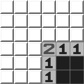

In [36]:
imshow(screen_arr)